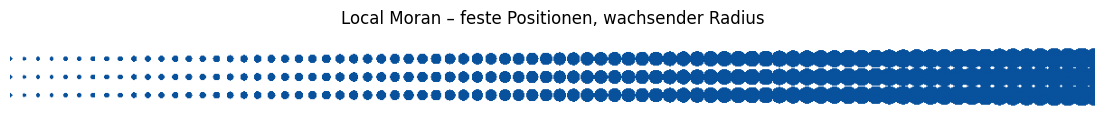

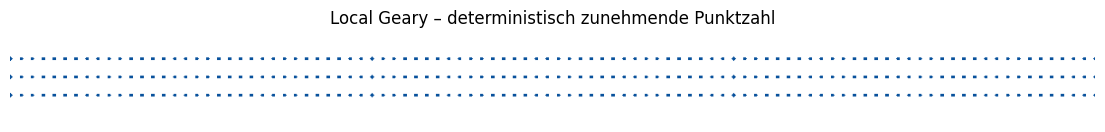

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

COLOR = np.array(mcolors.to_rgb("#08519c"))

# ----------------------------------------------------
# MORAN: feste Positionen, wachsender Radius
# ----------------------------------------------------

def moran_scale(width=1200, height=100, rows=3):
    img = np.ones((height, width, 3))

    # feste y-Positionen
    ys = np.linspace(height*0.3, height*0.7, rows)
    # feste x-Positionen für Kreise
    xs = np.linspace(0, width, 80)

    # per Pixel entlang der x-Achse wachsende Radien
    for xi, x in enumerate(xs):
        t = xi / (len(xs) - 1)
        r = 2 + t * 10   # Radius wächst linear

        for cy in ys:
            yy, xx = np.ogrid[:height, :width]
            mask = (xx - x)**2 + (yy - cy)**2 <= r**2
            img[mask] = COLOR

    return img


# ----------------------------------------------------
# GEARY: feste Rasterpunkte, deterministisch mehr aktiv
# ----------------------------------------------------

def geary_scale(width=1200, height=100, rows=3, cols=100):
    img = np.ones((height, width, 3))

    ys = np.linspace(height*0.3, height*0.7, rows)
    xs = np.linspace(0, width, cols)

    total = rows * cols

    for i in range(cols):
        t = i / (cols - 1)
        n_active = int(t * total)

        # deterministische Aktivierung: Zeilenweise
        for idx in range(n_active):
            row = idx // cols
            col = idx % cols
            if row < rows:
                cx, cy = xs[col], ys[row]

                r = 2  # konstante Punktgröße
                yy, xx = np.ogrid[:height, :width]
                mask = (xx - cx)**2 + (yy - cy)**2 <= r**2
                img[mask] = COLOR

    return img


# ----------------------------------------------------
# RENDERING
# ----------------------------------------------------

def show(img, title):
    plt.figure(figsize=(14, 2))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


moran_img = moran_scale()
geary_img = geary_scale()

show(moran_img, "Local Moran – feste Positionen, wachsender Radius")
show(geary_img, "Local Geary – deterministisch zunehmende Punktzahl")

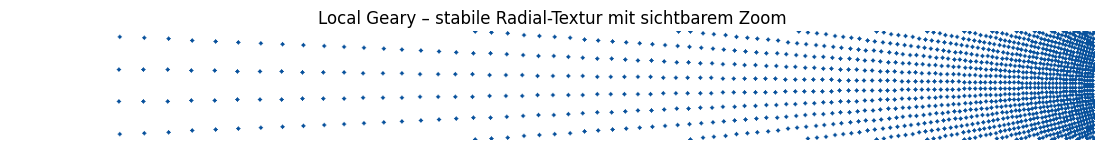

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

COLOR = np.array(mcolors.to_rgb("#08519c"))

def geary_radial_stable(width=1200, height=120,
                        n_rays=48, n_points=100, point_radius=2):

    img = np.ones((height, width, 3))

    yy, xx = np.ogrid[:height, :width]

    # ✔ Zentrum gut sichtbar aber außerhalb rechts
    cx = width * 1.1
    cy = height / 2

    # ✔ Winkelbereich so, dass alle Strahlen im Bild bleiben
    angle_span = np.deg2rad(80)  # ±20°
    angles = np.linspace(-angle_span/2, angle_span/2, n_rays)

    # ✔ Radien so, dass Punkte garantiert im Bild auftauchen
    r_max = width * 1.0   # weit draußen (links sichtbar)
    r_min = width * 0.1   # rechts Verdichtung (nah am Rand)

    # ✔ exponentielle Verdichtung
    radii = np.geomspace(r_max, r_min, n_points)

    for theta in angles:
        for r in radii:

            x = int(cx - r * np.cos(theta))
            y = int(cy - r * np.sin(theta))

            if 0 <= x < width and 0 <= y < height:
                mask = (xx - x)**2 + (yy - y)**2 <= point_radius**2
                img[mask] = COLOR

    return img


def show(img, title):
    plt.figure(figsize=(14, 2))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


img = geary_radial_stable()
show(img, "Local Geary – stabile Radial-Textur mit sichtbarem Zoom")

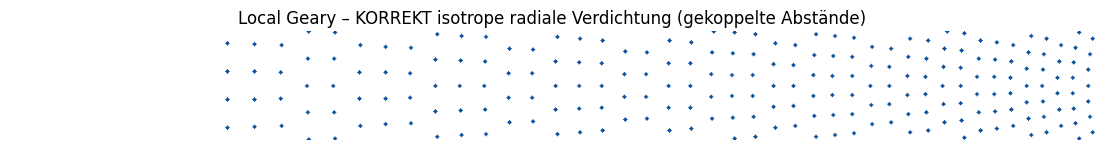

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

COLOR = np.array(mcolors.to_rgb("#08519c"))

def geary_radial_isotropic(width=1200, height=120,
                           n_rings=60, base_dr=20,
                           compression=3.0, c=1.0,
                           point_radius=2):

    img = np.ones((height, width, 3))
    yy, xx = np.ogrid[:height, :width]

    cx = width * 1.2
    cy = height / 2

    # Radial steps: groß → klein
    step_factors = np.linspace(1.0, 1.0 / compression, n_rings)
    step_factors /= step_factors.sum()

    drs = base_dr * n_rings * step_factors
    radii = [np.sum(drs)]
    for dr in drs[:-1]:
        radii.append(radii[-1] - dr)
    radii = np.array(radii)

    theta_center = np.deg2rad(0)
    max_angle = np.deg2rad(20)   # 40° span total

    for r, dr in zip(radii, drs):

        # KORREKT: gekoppelte Winkelauflösung
        dtheta = c * dr / max(r, 1e-6)   

        # RING: verschiedene Anzahl Punkte abhängig von r
        n_theta = int(2 * max_angle / dtheta) + 1
        thetas = np.linspace(-max_angle, max_angle, n_theta)

        for theta in thetas:
            x = int(cx - r * np.cos(theta))
            y = int(cy - r * np.sin(theta))

            if 0 <= x < width and 0 <= y < height:
                mask = (xx - x)**2 + (yy - y)**2 <= point_radius**2
                img[mask] = COLOR

    return img


def show(img, title):
    plt.figure(figsize=(14, 2))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


img = geary_radial_isotropic()
show(img, "Local Geary – KORREKT isotrope radiale Verdichtung (gekoppelte Abstände)")